In [5]:
import json
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('higgstachyon/kannada-mnist', path='./data', unzip=True)

Downloaded data from kaggle

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, roc_auc_score,classification_report
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from mlflow.sklearn import log_model
from mlflow.tracking import MlflowClient
import streamlit as st
import time
import pickle

In [23]:
# Step 1: Data Loading
def load_data(file_path):
    data = np.load(file_path)
    return data["arr_0"]

# Step 2: Load Kannada MNIST dataset
train_file_path = 'data/X_kannada_MNIST_train.npz'
label_train_file_path = 'data/y_kannada_MNIST_train.npz'

test_file_path = 'data/X_kannada_MNIST_test.npz'
label_test_file_path = 'data/y_kannada_MNIST_test.npz'

X_train = load_data(train_file_path)
X_test = load_data(test_file_path)

y_train = load_data(label_train_file_path)
y_test = load_data(label_test_file_path)

Sampling the data for demo be aware of the sampling the data because x_train and y_train fit and transform the data  before training


In [24]:

# Split the data into training (5000 samples) and testing (500 samples)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=15000, test_size=1500,)

In [25]:

# Flatten the image data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Step 3: Data Preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
pca_transformer = PCA(n_components=20, random_state=42)
preprocessor = Pipeline([('scaler', scaler), ('pca', pca_transformer)])

In [27]:
# Function to plot ROC curves
def plot_roc_curves(roc_auc_data, model_name):
    plt.figure(figsize=(8, 6))
    for i in range(roc_auc_data["n_classes"]):
        plt.plot(
            roc_auc_data["fpr"][i], roc_auc_data["tpr"][i],
            label=f'Class {roc_auc_data["class_names"][i]} (AUC = {roc_auc_data["roc_auc"][i]:.2f})',
        )
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for each class in model {model_name}")
    plt.legend()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix, annot=True, fmt="g", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{title}")
    plt.show()


In [28]:
# Step 4: Define classifiers and their hyperparameter grids
classifiers = {
    'SVC': (SVC(probability=True), {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}),
}

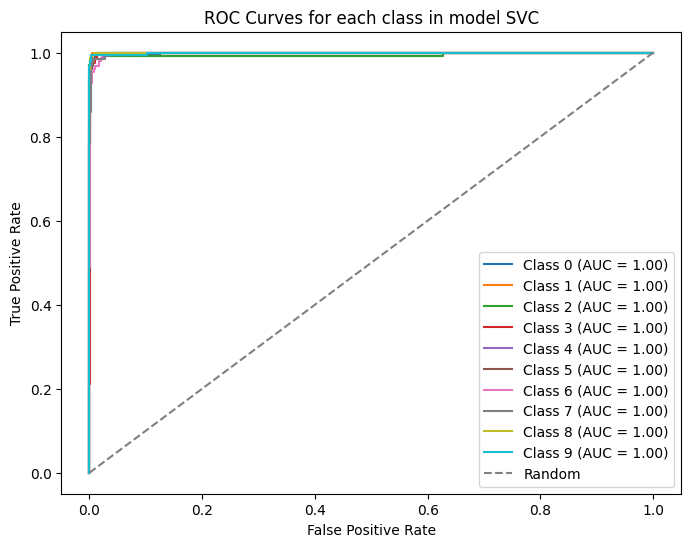

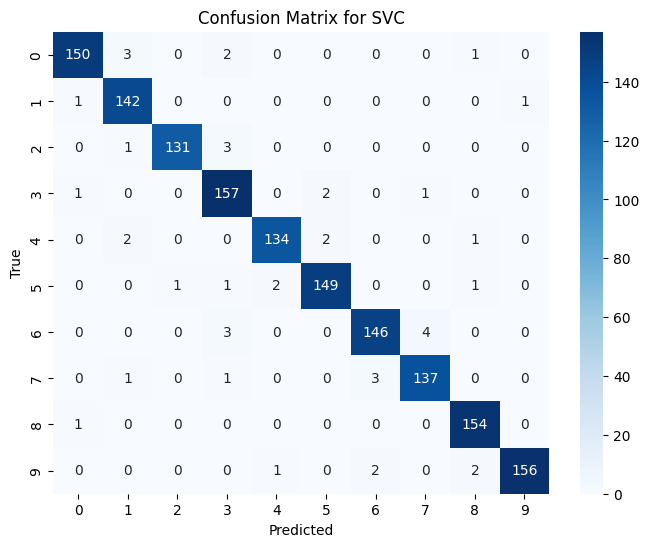

In [29]:

# Results initialization
results_list = []

# Step 5: Model Training and Evaluation Loop
mlflow.set_experiment("Kannada_MNIST_Classification")

# Step 5: Model Training and Evaluation Loop
class_names = [str(i) for i in range(10)]  # Assuming 10 classes

mlflow.set_experiment("Kannada_MNIST_Classification")
for clf_name, (clf, param_grid) in classifiers.items():
    with mlflow.start_run():
        # Log Dataset Size
        mlflow.log_param("dataset_size", len(X_train))

        # Log PCA components
        mlflow.log_param("PCA components", 20)

        # Log classifier
        mlflow.log_param("classifier", clf_name)

        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])

        # Update GridSearchCV to use precision as the scoring metric
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision_macro')

        start_time = time.time()
        grid_search.fit(X_train, y_train)
        training_time = time.time() - start_time
        mlflow.log_metric("Training time", training_time)

        y_pred = grid_search.predict(X_test)
        y_prob = grid_search.predict_proba(X_test)

        # Evaluate the best model on the validation set
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1_score_ = f1_score(y_test, y_pred, average='macro')
        roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")

        # Log metrics
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1 Score", f1_score_)
        mlflow.log_metric("ROC AUC Score", roc_auc)

        # Log model
        mlflow.sklearn.log_model(grid_search, "model")

        # Plot ROC curves
        roc_auc_data = {
            "n_classes": 10,
            "fpr": dict(),
            "tpr": dict(),
            "roc_auc": dict(),
            "class_names": class_names,
        }
        for i in range(10):
            roc_auc_data["fpr"][i], roc_auc_data["tpr"][i], _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
            roc_auc_data["roc_auc"][i] = auc(roc_auc_data["fpr"][i], roc_auc_data["tpr"][i])
        plot_roc_curves(roc_auc_data, clf_name)

        # Plot confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(conf_matrix, class_names, f"Confusion Matrix for {clf_name}")